In [1]:
! pip install --upgrade pip

In [2]:
! pip install -U matplotlib

  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl (8.1 MB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.2 MB 6.3 MB/s eta 0:00:01
   ------------------------------------- -- 2.1/2.2 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 4.9 MB/s eta 0:00:00
Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --------------- ------------------------ 1.0/2.7 MB 5.0 MB/s eta 0:00:01
   ------------------------------- -------- 2.1/2.7 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 5.0 MB/s eta 0:00:00

   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsing]
   ----- ---

In [14]:
# Функция draw_gene рисует экзон-интронную структуру гена по выравниванию и показывает положение полиморфизмов или иных точек на схеме гена.
# В fasta-файле должны быть представлены выравненные последовательности хромосомы (название последовательности должно содержать 'chr'),
# экзонов ('exon'), белок-кодирующей части ('cds'). Ген должен быть ориентирован в прямом направлении.
# Кооридинаты точек для подписей задаются в списке polymorphisms по координатам на последовательности хромосомы (chr) из выравнивания по примеру:
# polymorphisms = [(1408, 1408, 'с.234T>C'), (начало_патча, конец_патча, 'подпись_патча')].
# переменные vertical_positions и min_marker_dist указывать для каждого нового гена не обязательно, но можно менять по необходимоси.


def draw_gene(fasta_file = 'A_TraesCS2A02G500400_GS2-2A.fasta',
              gene_name = 'GS2-2A',
              gene_id = 'TraesCS2A02G500400',
              polymorphisms = [(2170, 2170, 'c.384-12C>T'), (2722, 2722, 'с.627-17T>C'), (2879, 2879, 'с.755+12T>G'),
                              (3611, 3611, 'с.922+61C>T'), (3624, 3624, 'с.922+74insT'), (4051, 4051, 'с.1026G>A'),
                              (4127, 4127, 'с.1083+19T>C'), (4132, 4132, 'с.1083+24insTTC'), (4707, 4720, 'del'),
                              (5212, 5219, 'del'), (5228, 5228, 'T>C'), (5243, 5243, 'G>C')],
              primer_file = 'TraesCS1B02G206600_primers.txt',
              marker_file = 'TraesCS6A02G269600_marker.txt',
              primer_positions = [0.62, 0.18, 0.8, 0.05, 0.62, 0.18, 0.8, 0.0],
              marker_positions = [0.62, 0.18, 0.8, 0.05, 0.62, 0.18, 0.8, 0.0],
              polymorphism_positions = [0.62, 0.18, 0.8, 0.05, 0.62, 0.18, 0.8, 0.0],
              min_marker_dist_fraction = 0.1):
    
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import os

    def parse_fasta(aligned_sequences):
        # Split the input into blocks for each sequence
        blocks = aligned_sequences.strip().split('>')
        data = {}
    
        for block in blocks:
            if not block.strip():
                continue
            lines = block.strip().split('\n')
            header = lines[0].strip()
            sequence = ''.join(lines[1:])  # Retain gaps for alignment purposes
        
            if 'chr' in header.lower():
                chrom_start = 1
                data['chromosome'] = (sequence, chrom_start)
        
            elif 'exon' in header.lower():
                data['exons'] = sequence
        
            elif 'cds' in header.lower():
                data['cds'] = sequence
    
        return data

    def find_islands_of_equality(chromosome_seq, target_seq, chrom_start):
        islands = []
        start = None
    
        for i in range(len(chromosome_seq)):
            if chromosome_seq[i] == target_seq[i] and chromosome_seq[i] != '-':
                if start is None:
                    start = i
            else:
                if start is not None:
                    islands.append((chrom_start + start, chrom_start + i - 1))
                    start = None
    
        # Check if there was an ongoing island at the end
        if start is not None:
            islands.append((chrom_start + start, chrom_start + len(chromosome_seq) - 1))
    
        return islands

    def structure(aligned_sequences):
        data = parse_fasta(aligned_sequences)
    
        chromosome_seq, chrom_start = data['chromosome']
        exon_seq = data['exons']
        cds_seq = data['cds']
    
        # Find exon positions
        exon_islands = find_islands_of_equality(chromosome_seq, exon_seq, chrom_start)
    
        # Find CDS positions
        cds_islands = find_islands_of_equality(chromosome_seq, cds_seq, chrom_start)
    
        # Print results
        print(f"Exon Positions: {exon_islands}")
        print(f"CDS Positions: {cds_islands}")

        chromosome_length = len(chromosome_seq)

        return(chromosome_length, exon_islands, cds_islands)
    
    
    def rev_compl(seq): # make reverse complement sequence
        seq = seq[::-1].upper()
        seq = seq.translate(str.maketrans(dict(zip('ATGC', 'TACG'))))
        return(seq)

    def find_primer_coordinates(name, seq, chromosome_seq):
        start = -1
        end = -1
        start_f = chromosome_seq.find(seq)
        start_r = chromosome_seq.find(rev_compl(seq))
        if start_f >= 0:
            start = start_f
            end = start_f + len(seq)
        elif start_r >= 0:
            start = start_r + len(seq)
            end = start_r
        return(start, end, name)


    # Example of aligned sequences input
    f1 = open(fasta_file, 'r')
    aligned_sequences = f1.read()
    f1.close()

    # Example data (positions are illustrative)
    chromosome_length, exons, cds = structure(aligned_sequences)

    chromosome_seq, _ = parse_fasta(aligned_sequences)['chromosome']
    primers = []

    if os.path.exists(primer_file):
        f2 = open(primer_file, 'r')

        for line in f2:
            columns = line.strip().split()
            if len(columns) < 2:
                continue
            else:
                primer_name = columns[0]
                primer_sequence = columns[1]
                primer_coordinates = find_primer_coordinates(primer_name, primer_sequence, chromosome_seq=chromosome_seq)
                primers.append(primer_coordinates)
    
    markers = []

    if os.path.exists(marker_file):
        f2 = open(marker_file, 'r')

        for line in f2:
            columns = line.strip().split()
            if len(columns) < 2:
                continue
            else:
                primer_name = columns[0]
                primer_sequence = columns[1]
                primer_coordinates = find_primer_coordinates(primer_name, primer_sequence, chromosome_seq=chromosome_seq)
                markers.append(primer_coordinates)

    cds_color = 'orange'

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 2))

    # Draw chromosome
    # Draw gene introns
    ax.plot([exons[0][0], exons[-1][1]], [0.5, 0.5], color='black', linewidth=1, zorder=0)

    min_marker_dist = int(min_marker_dist_fraction * chromosome_length)

    # Draw exons and UTRs
    for exon_start, exon_end in exons:   
        # Determine UTRs within each exon
        cds_present_in_exon = False
        
        for cds_start, cds_end in cds:
            if cds_start > exon_end or cds_end < exon_start:
                continue  # CDS is not in this exon
            utr_left = max(exon_start, cds_start) - exon_start
            utr_right = exon_end - min(exon_end, cds_end)
            cds_present_in_exon = True
        
            # Draw UTRs as blue boxes
            if utr_left > 0 and utr_right == 0:
                ax.add_patch(patches.Rectangle((exon_start, 0.45), utr_left, 0.1, color='blue'))
                ax.add_patch(patches.Rectangle((exon_start + utr_left, 0.4), exon_end - (exon_start + utr_left), 0.2, color=cds_color))
            if utr_right > 0 and utr_left == 0:
                ax.add_patch(patches.Rectangle((min(exon_end, cds_end), 0.45), utr_right, 0.1, color='blue'))
                ax.add_patch(patches.Rectangle((exon_start, 0.4), exon_end - exon_start -utr_right, 0.2, color=cds_color))
            if utr_left > 0 and utr_right > 0:
                ax.add_patch(patches.Rectangle((exon_start, 0.45), utr_left, 0.1, color='blue'))
                ax.add_patch(patches.Rectangle((exon_end - utr_right, 0.45), utr_right, 0.1, color='blue'))
                ax.add_patch(patches.Rectangle((exon_start + utr_left, 0.4), exon_end - (exon_start + utr_left + utr_right), 0.2, color=cds_color))
            if utr_left == 0 and utr_right == 0:
                ax.add_patch(patches.Rectangle((exon_start, 0.4), exon_end - exon_start, 0.2, color=cds_color))
        
        if cds_present_in_exon == False:
            ax.add_patch(patches.Rectangle((exon_start, 0.45), exon_end - exon_start, 0.1, color='blue'))

    if len(polymorphisms) > 0:
        prev_start = -10000
        i = 0
    
        for start, end, title in polymorphisms:
            # print(abs(start - prev_start), title)
            if abs(start - prev_start) < min_marker_dist:
                i += 1
                if i >= len(polymorphism_positions):
                    i = 0
            else:
                i = 1
            ax.add_patch(patches.Rectangle((start, polymorphism_positions[i]), end - start, 0.2, color='black'))
            ax.text(end + chromosome_length/200, polymorphism_positions[i] + 0.08, title, color ="black")
            prev_start = start
    
    if len(primers) > 0:
        prev_start = -10000
        i = 0
    
        for start, end, title in primers:
            title = title.replace('chr', gene_name + '-') # start primer name with gene name instead of chr
            if start < 0 or end < 0:
                print(title, "not found")
                continue
            if abs(start - prev_start) < min_marker_dist:
                i += 1
                if i >= len(primer_positions):
                    i = 0
            else:
                i = 0
            ax.add_patch(patches.FancyArrow(start, primer_positions[i]+0.125, end - start, 0, width=0.025,
                                             length_includes_head=False, head_width=0.1, head_length=50, color='red'))
            ax.text(end + 2*chromosome_length/100, primer_positions[i] + 0.08, title, color ="black")
            prev_start = start

    if len(markers) > 0:
        prev_start = -10000
        i = 0
    
        for start, end, title in markers:
            title = title.replace('chr', gene_name + '-') # start primer name with gene name instead of chr
            if start < 0 or end < 0:
                print(title, "not found")
                continue
            if abs(start - prev_start) < min_marker_dist:
                i += 1
                if i >= len(primer_positions):
                    i = 0
            else:
                i = 0
            ax.add_patch(patches.FancyArrow(start, marker_positions[i]+0.125, end - start, 0, width=0.025,
                                             length_includes_head=False, head_width=0.1, head_length=50, color='blue'))
            ax.text(end + 2*chromosome_length/100, marker_positions[i] + 0.08, title, color ="black")
            prev_start = start

    # Set limits and labels
    ax.set_xlim(0, chromosome_length)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel('Position, bp')
    ax.set_title('${' + gene_name +'}$ (' + gene_id + ')')
    k = 0
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        if k == 2:
            spine.set_visible(True)
        k += 1

    # Add an arrow at the end of the last exon
    last_exon_end = exons[-1][1]
    arrow = patches.FancyArrow(last_exon_end, 0.5, 50, 0, width=0.025, head_width=0.1, head_length=50, color='green')
    ax.add_patch(arrow)

    plt.savefig(gene_id + '_' + gene_name + '.png', dpi=400, bbox_inches='tight')
    plt.savefig(gene_id + '_' + gene_name + '.svg', bbox_inches='tight')

    plt.show()


Exon Positions: [(1501, 1786), (1883, 2100), (2637, 3053), (7532, 8296)]
CDS Positions: [(1677, 1786), (1883, 2100), (2637, 3053), (7532, 8013)]


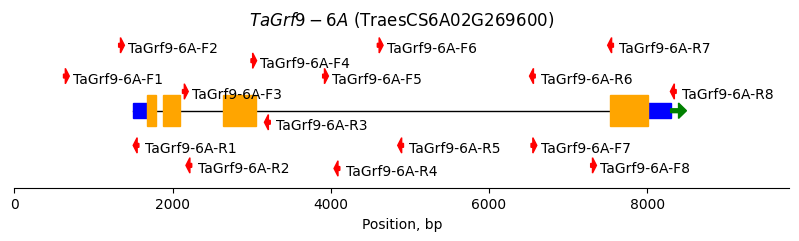

In [8]:
draw_gene(fasta_file = 'TraesCS6A02G269600_GRF9-6A.fasta',
          gene_name = 'TaGrf9-6A',
          gene_id = 'TraesCS6A02G269600',
          primer_file = 'TraesCS6A02G269600_primers.txt',
          polymorphisms = [],
          vertical_positions = [0.60, 0.15, 0.8, 0.02, 0.50, 0.3, 0.7, 0.0],
          min_marker_dist_fraction = 0.2)

Exon Positions: [(946, 1165), (1262, 1479), (2016, 2605)]
CDS Positions: [(1056, 1165), (1262, 1479), (2016, 2434)]


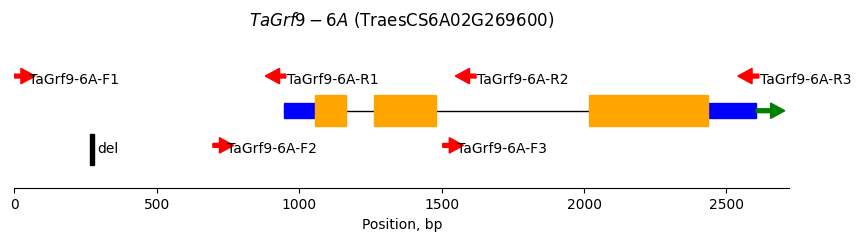

In [16]:
draw_gene(fasta_file = 'Grf9-6A_for_short_gene_scheme.fasta',
          gene_name = 'TaGrf9-6A',
          gene_id = 'TraesCS6A02G269600',
          primer_file = 'TraesCS6A02G269600_primers_short.txt',
          polymorphisms = [(267, 278, 'del')],
          vertical_positions = [0.60, 0.15, 0.8, 0.02, 0.50, 0.3, 0.7, 0.0],
          min_marker_dist_fraction = 0.2)

Exon Positions: [(946, 1165), (1262, 1479), (2016, 2605)]
CDS Positions: [(1056, 1165), (1262, 1479), (2016, 2434)]


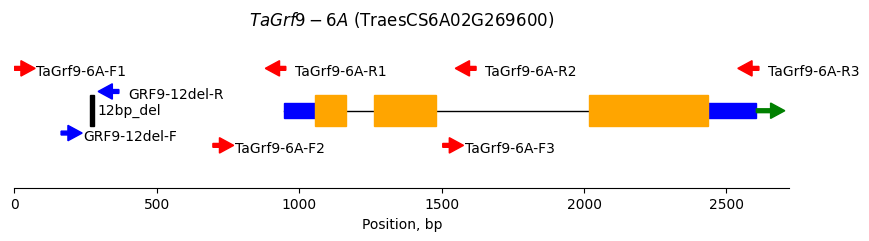

In [16]:
draw_gene(fasta_file = 'Grf9-6A_for_short_gene_scheme.fasta',
          gene_name = 'TaGrf9-6A',
          gene_id = 'TraesCS6A02G269600',
          primer_file = 'TraesCS6A02G269600_primers_short.txt',
          marker_file= 'TraesCS6A02G269600_marker.txt',
          polymorphisms = [(267, 278, '12bp_del')],
          polymorphism_positions=[0.4, 0.4],
          primer_positions = [0.65, 0.15, 0.85, 0.02, 0.50, 0.3, 0.7, 0.0],
          marker_positions = [0.23, 0.5],
          min_marker_dist_fraction = 0.2)